In [47]:
import warnings
warnings.filterwarnings('ignore')

#### 시계열 데이터를 LSTM으로 예측

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import matplotlib.pyplot as plt

#### 데이터 준비
yfinance 라이브러리로 애플 주식 데이터 사용     
종가 :     
- 일반적으로 주가예측에 자주 사용되는 지표
- 하루 동안의 최종 거래 가격을 나타내어 전체적인 추세를 반영하는데 사용 

In [49]:
# !pip install yfinance

In [50]:
import yfinance as yf

# 애플주식(AAPL) 주식 데이터 다운로드
df = yf.download("AAPL", start="2015-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [51]:
df = df[['Close']]
df

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.288584
2015-01-05,23.604328
2015-01-06,23.606548
2015-01-07,23.937574
2015-01-08,24.857307
...,...
2019-12-24,68.732887
2019-12-26,70.096573


In [65]:
df = pd.read_csv("../Data/apple.csv",header=2)
df.columns =  ['Date','Close','1','2','3','4']

In [66]:
df = df[['Date','Close']]
df.head()

,Date,Close
0,2015-01-02,24.288584
1,2015-01-05,23.604328
2,2015-01-06,23.606548
3,2015-01-07,23.937574
4,2015-01-08,24.857307


In [67]:
df = df.set_index('Date')

In [68]:
df

,Close
Date,
2015-01-02,24.288584
2015-01-05,23.604328
2015-01-06,23.606548
2015-01-07,23.937574
2015-01-08,24.857307
...,...
2019-12-24,68.732887
2019-12-26,70.096573
2019-12-27,70.069969


#### 데이터 전처리
: LSTM은 데이터의 스케일에 민감하므로 MinMaxScaler를 사용해 데이터 정규화

In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 학습데이터와 테스트데이터로 분할 (80%학습, 20%테스트)
train_data_len = int(np.ceil(len(scaled_data) * 0.8))

# 학습데이터
train_data = scaled_data[0:int(train_data_len), :]
test_data = scaled_data[train_data_len - 60:, :]

In [70]:
train_data

array([[0.07231136],
       [0.05872229],
       [0.05876639],
       ...,
       [0.32903076],
       [0.33617433],
       [0.3370257 ]])

LSTM 모델은 과거 데이터를 사용해 다음 값을 예측하도록 설계   
60일간의 데이터를 입력으로 사용하여 다음날의 주가를 예측하는 방식 

In [54]:
# 학습 데이터 셋
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM 입력을 위한 3차원 형식 변환
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.07231136],
        [0.05872229],
        [0.05876639],
        ...,
        [0.14025725],
        [0.13587212],
        [0.14969191]],

       [[0.05872229],
        [0.05876639],
        [0.06534044],
        ...,
        [0.13587212],
        [0.14969191],
        [0.141099  ]],

       [[0.05876639],
        [0.06534044],
        [0.083606  ],
        ...,
        [0.14969191],
        [0.141099  ],
        [0.14030157]],

       ...,

       [[0.67083932],
        [0.68399205],
        [0.66475796],
        ...,
        [0.28456197],
        [0.33347778],
        [0.32865242]],

       [[0.68399205],
        [0.66475796],
        [0.64731495],
        ...,
        [0.33347778],
        [0.32865242],
        [0.32903076]],

       [[0.66475796],
        [0.64731495],
        [0.64486332],
        ...,
        [0.32865242],
        [0.32903076],
        [0.33617433]]])

#### LSTM 모델 정의 및 학습

In [55]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))
)

model.add(
    LSTM(50)
)

model.add(
    Dense(25)
)

model.add(
    Dense(1)
)


In [56]:
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error' # 평균제곱오차
)

In [57]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0097
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.5740e-04
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6447e-04
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3580e-04
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.7902e-04


#### 테스트 데이터 준비 및 예측

In [58]:
X_test = []
y_test = scaled_data[train_data_len:,:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [59]:
# 예측과 정규화 전 데이터로 돌리기
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


#### 평가

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [63]:
# 실제 주가와 예측된 주가 준비
actual_prices = df[train_data_len:]['Close'].values 
predicted_prices = predictions.flatten()

In [66]:
# 평가 지표 계산 
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

In [67]:
# 평가 결과 출력
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")

Mean Squared Error (MSE) : 2.71
Root Mean Squared Error (RMSE) : 1.65
Mean Absolute Error (MAE) : 1.30


#### 결과 시각화
: 모델 예측 결과와 실제 주가를 비교

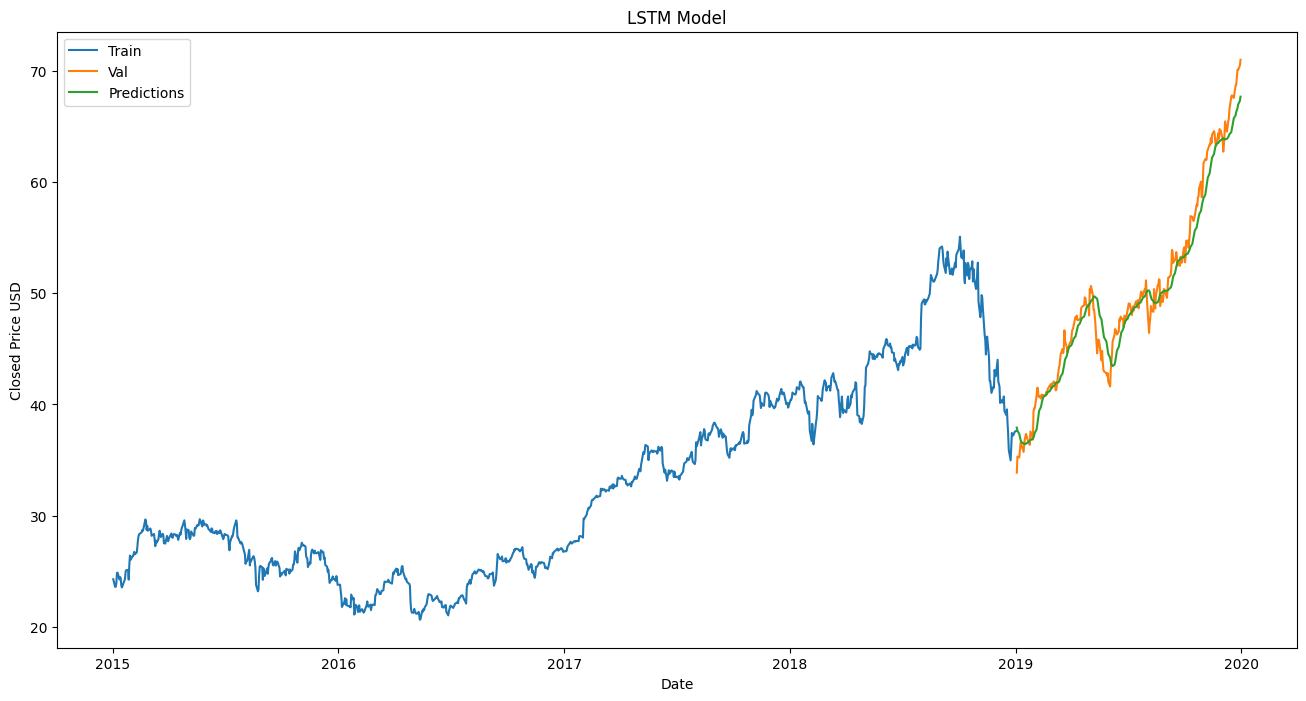

In [68]:
train = df[:train_data_len]
valid = df[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Closed Price USD')

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [ ]:
# 구개의 문장이
# 
# N-gram 
# 코사인 유사도
# 유클리안 유사도
# 맨하튼 유사ㅏ도

In [ ]:
# 레벤슈타인 거리(Levenshtein Distance)
# 두개의 문자열이 어느 정도 다른지를 나타내는 것으로 편집거리(Edit Distance)라고도 한다
# - 의학 분야에서는 DNA배열의 유사성을 판단할때도 사용

In [24]:
from lvenshtein import Lvenshtein
lv = Lvenshtein



In [25]:
# 가나다라와 가마바라의 거리
print(lv.calc_distance("가나다라","가마바라"))

TypeError: Lvenshtein.calc_distance() missing 1 required positional argument: 'b'

In [ ]:
# 신촌역과 가즏
samples = ['신촌역','신천군','신천역','마곡역','신발']
base = samples[0]
r = sorted(samples, key = lambda n : lv.calc_distance(base , n) , n )

for n in r:
    

SyntaxError: positional argument follows keyword argument (1807499198.py, line 4)

In [36]:
# 코사인 유사도
a = " 딥러닝을 매우 재미있는 기룻이라 공부하고 있습니다"
b = " 공부하고 재미있는 딥러닝을 배우고  있습니다"

from sklearn.feature_extraction.text import TfidfVectorizer
sentences = (a,b)
tfid_Vectiorizer = TfidfVectorizer()

In [29]:
sentences

(' 딥러닝늠 매우 재미있는 기룻이라 공부하고 있습니다', ' 공부하면 재미있는 딥러닝을 배우고  있습니다')

In [37]:
# 문장 벡터화 하기 : 사전 만들기
tfid_matrix = tfid_Vectiorizer.fit_transform(sentences)


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# 첫번때 문장과 두번째 문장 비교
cos_similar = cosine_similarity(tfid_matrix[0:1], tfid_matrix[1:2])
print("코사인 유사도 측정:", cos_similar)

코사인 유사도 측정: [[0.58033298]]


In [41]:
# 유사도를 이용한 추천 시스템 구현
# :코사인 유
import pandas as pd
data = pd.read_csv("../Data/movies_metadata.csv")
data.head()

C:\Users\TJ\AppData\Local\Temp\ipykernel_2428\3079912815.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [42]:
data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [43]:
data[['title','overview']].head()

,title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [47]:
# 상위 2만개
df = data[['title','overview']].head(20000)
df['overview'] = df['overview'].fillna("")

In [49]:
tfidf = TfidfVectorizer(stop_words='english')
tfid_matrix = tfidf.fit_transform(df['overview'])
tfid_matrix.shape

(20000, 47487)

In [50]:
cosine_sim = cosine_similarity(tfid_matrix, tfid_matrix)
cosine_sim.shape

(20000, 20000)

In [51]:
# 기존데이텊레임으로 부터 영화 타이틀ㅇㄹ key, 영화의 인덱스를 value오 하는 딕셔너리
title_to_index = dict(zip(data['title'], data.index))

In [52]:

idx = title_to_index['Father of the Bride Part II']
idx

4

In [ ]:
# 선택한 영화의 제목을 입력하면 코사인 유사도을 통해 
# 가장 오버뷰가 유사한 10개의 영화를 찾아내는 함수

def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영호의 타이틀로 부터 해당 영화의 인덱스를 받아온다
    idx = title_to_index[title]
    # 해당 영호와 모든 영화와의 유사도를 가져온다.
    sim_scores = list(enumerate(cosine_sim[idx]))
    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 가장 유사한 10개의 영화를 받아온다
    sim_scores = sim_scores[1:11]                # 0번은 자기자신이다
    # 가장 유사한 10개의 영화으 인덱스를 엊는다
    movies_indexes = [idx[0] for idx in sim_scores]
    # 가장 유ㅏ한 10개의 영화의 제목을 리턴한다
    return data['title'].iloc[movies_indexes]

In [57]:
# 영화 : The Dark Knight Rises
get_recommendations("The Dark Knight Rises")

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

In [58]:
# 영화 : The Dark Knight Rises
get_recommendations("Jumanji")

6166                       Brainscan
8801                         Quintet
17223                 The Dark Angel
9503                       Word Wars
13601    The Mindscape of Alan Moore
16843                         DeVour
8079                         Masques
6055                Poolhall Junkies
19726                 Wreck-It Ralph
2486                        eXistenZ
Name: title, dtype: object